In [33]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import re
import numpy as np
import pandas as pd
import gensim
import nltk

from nltk.stem.snowball import SnowballStemmer

from gensim.corpora import Dictionary, MmCorpus
from gensim.models import ldamodel, lsimodel

from sklearn.cluster import KMeans
from sklearn.manifold import MDS
from sklearn.decomposition import PCA

In [4]:
def load_dataset(filename):
    file = open(filename, 'r')

    acc_names = []
    tweets = []

    for line in file:
        line = line.strip()
        parts = line.split('###')
        acc_names.append(parts[0])
        tweets.append(parts[1])

    return acc_names, tweets

In [5]:
# config variables
num_topics=4

In [6]:
# definisikan beberapa fungsi untuk kebutuhkan pre-processing, pre-processing yang dilakukan adalah
# 1. lowercasing
# 2. stopword removal
# 3. stemming

stemmer = SnowballStemmer("english")
stopwords = nltk.corpus.stopwords.words('english')

def preprocess(text):

    # tokenizing and lowercasing
    tokens = [word.lower() for word in text.split()]
    filtered_tokens = []

    # buat yang bukan terdiri dari alfabet, dan merupakan stopword
    for token in tokens:
        if re.search('[a-zA-Z]', token) and (token not in stopwords):
            filtered_tokens.append(token)

    # lakukan stemming dengan snowball stemmer
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

In [7]:
# Kita load dokumen twitter, dan lakukan preprocessing terhadap tweet yang sudah di-load
acc_names, tweets = load_dataset("twitter.txt")

# Lakukan pre-process untuk setiap tweet pada koleksi "tweets" kita
# Gunakan List Comprehension untuk mempermudah hidup kita
tweets = [preprocess(tweet) for tweet in tweets]

In [8]:
# membuat term dictionary dari korpus kita, dimana setiap kata unik akan diberikan sebuah index
dictionary = Dictionary(tweets)

# buang term yang:
# 1. muncul di kurang dari 2 dokumen
# 2. muncul di lebih dari 0.9*(total_dok) dokumen
dictionary.filter_extremes(no_below=2, no_above=0.9)

# ubah dictionary menjadi object bag-of-words reference
# ingat bahwa dalama LDA, dokumen diasumsikan dengan bag-of-words model
corpus = [dictionary.doc2bow(tweet) for tweet in tweets]

In [48]:
# Run the LDA !
# lda = ldamodel.LdaModel(corpus, num_topics=num_topics, id2word=dictionary, random_state=1, iterations=5000)
lda = lsimodel.LsiModel(corpus, num_topics=num_topics, id2word=dictionary)

In [49]:

# tampilkan topic matrix
topics_matrix = lda.show_topics(formatted=False)

for topic_no, topic_words in topics_matrix:

    print ('topic number: {}'.format(topic_no))

    # default: top-10 kata yang paling tinggi probabilitasnya
    for word, prob in topic_words:
        print (word, prob)

topic number: 0
samsung 0.569450483229191
galaxi 0.4600082240489243
note 0.36977819922289323
iphon 0.30583727211129696
leagu 0.252185111761406
champion 0.24167465131952323
time 0.11026118624489066
year 0.10798110206520756
full 0.09514996018605537
still 0.08925825364615349
topic number: 1
leagu 0.6161956881090623
champion 0.5871219620209108
samsung -0.24933798093875081
galaxi -0.19947051924853998
note -0.161671424231475
premier 0.12768783083197358
club 0.12614770428359953
iphon -0.12558737335257666
league. 0.10866317305149654
chelsea 0.10417389455442705
topic number: 2
referendum 0.6705314663999484
catalunya 0.5553513130271788
catalan 0.22396337811774178
support 0.21550103319547456
spanish 0.14628019942544992
block 0.14075350826826624
referendum, 0.12437357871861836
barcelona 0.10199862319150932
watch 0.10103118357056609
due 0.1008174560698354
topic number: 3
iphon 0.8698735830970042
note -0.28248394834723356
samsung -0.19625605062044346
year 0.18683490082167334
galaxi -0.16177379814925

In [50]:
print (lda.show_topics())

[(0, '0.569*"samsung" + 0.460*"galaxi" + 0.370*"note" + 0.306*"iphon" + 0.252*"leagu" + 0.242*"champion" + 0.110*"time" + 0.108*"year" + 0.095*"full" + 0.089*"still"'), (1, '0.616*"leagu" + 0.587*"champion" + -0.249*"samsung" + -0.199*"galaxi" + -0.162*"note" + 0.128*"premier" + 0.126*"club" + -0.126*"iphon" + 0.109*"league." + 0.104*"chelsea"'), (2, '0.671*"referendum" + 0.555*"catalunya" + 0.224*"catalan" + 0.216*"support" + 0.146*"spanish" + 0.141*"block" + 0.124*"referendum," + 0.102*"barcelona" + 0.101*"watch" + 0.101*"due"'), (3, '0.870*"iphon" + -0.282*"note" + -0.196*"samsung" + 0.187*"year" + -0.162*"galaxi" + 0.124*"watch" + 0.112*"so," + 0.076*"new" + -0.069*"main" + 0.069*"time"')]


In [52]:
print(lda.get_topics(dictionary.doc2bow(tweet)))

TypeError: get_topics() takes 1 positional argument but 2 were given

In [44]:
# bentuk terlebih dahulu vektor dokumen/tweet
# vektor tweet/dokumen = vektor probabilitas terhadap masing-masing topik
tweet_vectors = []
for tweet in tweets:
    probs = [prob for (_,prob) in lda.get_document_topics(dictionary.doc2bow(tweet))]
    tweet_vectors.append(probs)
tweet_vectors = np.array(tweet_vectors)

# kita set banyaknya cluster = banyaknya topik
num_clusters = num_topics

# gunakan algoritma K-Means, dan lakukan clustering !
km = KMeans(n_clusters=num_clusters)
km.fit(tweet_vectors)

# jika kita ingin melihat indeks cluster untuk setiap tweet/dokumen
clusters = km.labels_.tolist()

print(clusters)

[3, 0, 3, 2, 2, 1, 0, 2, 1, 1, 3, 3, 1, 0, 3, 0, 0, 3, 2, 2, 2, 1, 2, 2, 0, 2, 2, 2, 2, 2, 0, 1, 3, 3, 3, 1, 3, 1, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 2, 3]


In [53]:
print(tweet_vectors)

[[0.80618477 0.06746034 0.06336243 0.06299248]
 [0.05259623 0.8414018  0.05436617 0.0516358 ]
 [0.6244938  0.12520477 0.1251576  0.12514387]
 [0.04627742 0.04668002 0.8641156  0.04292697]
 [0.06562262 0.31141058 0.5585325  0.06443434]
 [0.1388234  0.06630667 0.06642415 0.72844577]
 [0.0520206  0.84520745 0.05082975 0.0519422 ]
 [0.03801076 0.41396883 0.51126695 0.03675345]
 [0.03630483 0.0404459  0.03735645 0.88589287]
 [0.06312862 0.42790595 0.06880143 0.44016403]
 [0.61494297 0.13042061 0.12802364 0.12661281]
 [0.614936   0.13042894 0.12802224 0.12661284]
 [0.03177203 0.3859676  0.0318071  0.5504533 ]
 [0.0421292  0.87191015 0.04315391 0.04280671]
 [0.6150019  0.13036804 0.1280188  0.12661128]
 [0.04186383 0.87270033 0.04261672 0.04281909]
 [0.05220068 0.8448282  0.05203149 0.05093963]
 [0.747111   0.08481783 0.08422901 0.08384211]
 [0.08335732 0.08499608 0.74552023 0.08612632]
 [0.05003056 0.05209616 0.8471128  0.05076052]
 [0.06254663 0.06308518 0.8091954  0.06517283]
 [0.06367312 

In [13]:

# untuk setiap cluster center, kita sort argumen/index berdasarkan nilai probabilitasnya
# karena index/argumen adalah id topik.
#
# jadi, secara intuisi, ini adalah cara untuk mencari topik major yang dibicarakan di sebuah cluster
# nantinya, wakil kata cluster akan diambil dari 2 topik major di setiap cluster
#
# ::-1 artinya reverse list

order_centroids = km.cluster_centers_.argsort()[:, ::-1]

cluster_names = {}
for i in range(num_clusters):
    print ("cluster %d words:" % i)
    
    # ambil 2 topik major untuk setiap cluster
    topic_words = []
    for ind in order_centroids[i, :1]:
        topic_words += [dictionary.get(word_id) for (word_id, prob) in lda.get_topic_terms(ind, topn=2)]
    
    cluster_names[i] = ','.join(topic_words)

    print (cluster_names[i])

cluster 0 words:
champion,leagu
cluster 1 words:
referendum,catalunya
cluster 2 words:
samsung,galaxi
cluster 3 words:
full,champion


In [14]:
### plot ke 2D ###

#reduksi dimensi dengan multidimensional scaling
mds = MDS(n_components=2)
pos = mds.fit_transform(tweet_vectors)  # shape (n_components, n_samples)

#pca = PCA(n_components=2)
#pos = pca.fit_transform(tweet_vectors)  # shape (n_components, n_samples)

# ambil hasil reduksi ke 2D untuk posisi x dan y --> agar bisa di-plot di bidang kartesius
xs, ys = pos[:, 0], pos[:, 1]

In [15]:
# fungsi yang digunakan untuk plot cluster dokumen berdsarkan distribusi topik yang dimilikinya
# xs adalah posisi axis dari semua dokumen (numpy list of real number)
# ys adalah posisi ordinat dari semua dokumen (numpy list of real number)
# clusters adalah list dari cluster index untuk masing-masing dokumen
# acc_names adalah list dari nama-nama dokumen (dalam hal ini, nama-nama akun tweet)
def plot_doc_cluster(xs, ys, clusters, acc_names):
    # warna cluster - maksimal 5 cluster
    cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}

    # gunakan Pandas untuk kemudahan proses data, terutama untuk grouping
    df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, acc_names=acc_names))
    groups = df.groupby('label') #group by cluster!!!

    fig, ax = plt.subplots(figsize=(17, 9)) # set size
    ax.margins(0.05)

    for name, group in groups:
        ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, label=cluster_names[name], color=cluster_colors[name], mec='none')
        ax.set_aspect('auto')
        ax.tick_params(axis= 'x', which='both', bottom='off', top='off', labelbottom='off')
        ax.tick_params(axis= 'y', which='both', left='off', top='off', labelleft='off')

    ax.legend(numpoints=1)  #show legend with only 1 point

    for i in range(len(df)):
        ax.text(df.ix[i]['x'], df.ix[i]['y'], df.ix[i]['acc_names'], size=8)

    plt.show()

# fungsi yang digunakan untuk plot distribusi kata per-topik yang ditemukan
def plot_word_dist_per_topic(topic_no, topics_matrix, width=0.5):
    _, topic_words = topics_matrix[topic_no]

    # hanya top-10 yang paling tinggi probabilitasnya
    words = []
    probs = []
    for word, prob in topic_words:
        words.append(word)
        probs.append(prob)

    ind = np.arange(len(words))

    plt.bar(ind, probs, width=width)
    plt.xticks(ind + width/2, words, rotation='vertical')
    plt.title('Word Distribution of Topic {}'.format(topic_no))
    plt.show()

AttributeError: 'DataFrame' object has no attribute 'ix'

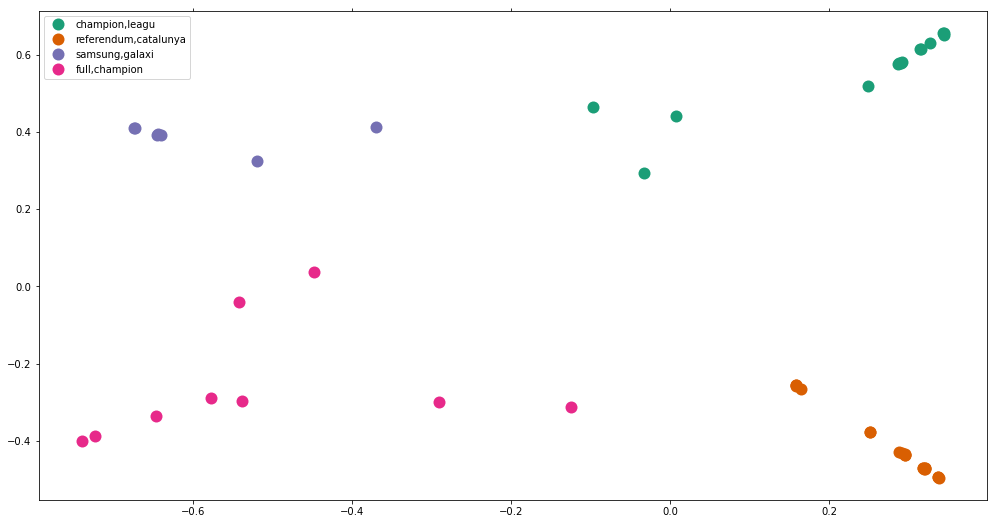

In [16]:
# plot cluster dokumen/tweet
plot_doc_cluster(xs, ys, clusters, acc_names)

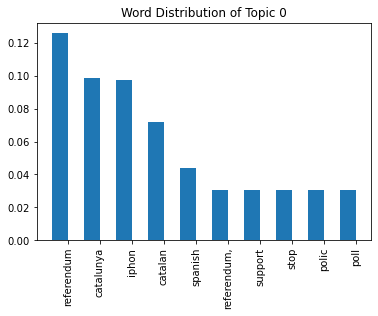

In [17]:
# plot word distribution untuk topic 0
plot_word_dist_per_topic(0, topics_matrix)

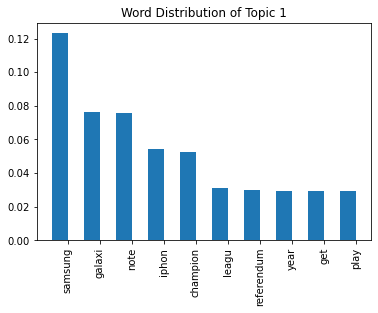

In [18]:

# plot word distribution untuk topic 1
plot_word_dist_per_topic(1, topics_matrix)

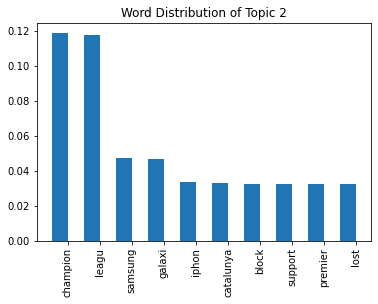

In [19]:
# plot word distribution untuk topic 2
plot_word_dist_per_topic(2, topics_matrix)

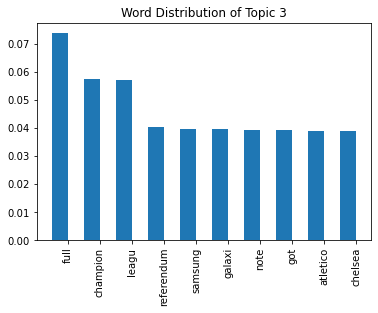

In [20]:
# plot word distribution untuk topic 3
plot_word_dist_per_topic(3, topics_matrix)